## Calculate SU: the number of Summer Days

Example notebook that runs icclim.

The example calculates the number of summer days (SU indicator) for the dataset chosen by the user on C4I.

We assume to have the **tas** variable in netCDF files in a `./data` folder for model `CMCC` and for one member `r1i1p1f1`.  
The data can be dowloaded using the [metalink](data/cmcc_tas.metalink) provided with this notebook.  
The data described in a `.metalink` file can be dowloaded with tools such as [aria2](https://aria2.github.io/) or a browser plugin such as [DownThemAll!](https://addons.mozilla.org/en-US/firefox/addon/downthemall/)
If you wish to use a different dataset, you can use the [climate 4 impact portal](https://www.climate4impact.eu/c4i-frontend/) to search and select the data you wish to use and a metalink file to the [ESGF](https://esgf.llnl.gov/) data will be provided.

The data is read using xarray and a plot of the time series over a specific region is generated, as well as an average spatial map. Several output types examples are shown.

To keep this example fast to run, the following period is considered: 2015-01-01 to 2019-12-31, and plots are shown over European region.

### Installation and preparation of the needed modules

In [26]:
%pip install icclim matplotlib nc_time_axis

Note: you may need to restart the kernel to use updated packages.


In [5]:
import datetime
import sys
from pathlib import Path

import cartopy.crs as ccrs
import cftime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import icclim

print("python: ", sys.version)
print("numpy: ", np.__version__)
print("xarray: ", xr.__version__)
print("pandas: ", pd.__version__)
print("icclim: ", icclim.__version__)
print("cftime: ", cftime.__version__)

python:  3.11.7 | packaged by conda-forge | (main, Dec 15 2023, 08:38:37) [GCC 12.3.0]
numpy:  1.26.2
xarray:  2023.10.1
pandas:  2.1.4
icclim:  6.6.0
cftime:  1.6.3


### Specification of the parameters

In [12]:
# studied period
dt1 = datetime.datetime(2015, 1, 1, tzinfo=datetime.timezone.utc)
dt2 = datetime.datetime(2019, 12, 31, tzinfo=datetime.timezone.utc)

DATA_DIR = Path("./data")
out_f = "su_icclim.nc"
filenames = [str(f) for f in DATA_DIR.glob("tas_day_CMCC*.nc")]
filenames

['data/tas_day_CMCC-ESM2_historical_r1i1p1f1_gn_19250101-19491231.nc',
 'data/tas_day_CMCC-ESM2_historical_r1i1p1f1_gn_19500101-19741231.nc',
 'data/tas_day_CMCC-ESM2_historical_r1i1p1f1_gn_19750101-19991231.nc',
 'data/tas_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_20900101-21001231.nc',
 'data/tas_day_CMCC-ESM2_historical_r1i1p1f1_gn_20000101-20141231.nc',
 'data/tas_day_CMCC-ESM2_historical_r1i1p1f1_gn_19000101-19241231.nc',
 'data/tas_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_20400101-20641231.nc',
 'data/tas_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_20650101-20891231.nc',
 'data/tas_day_CMCC-ESM2_historical_r1i1p1f1_gn_18500101-18741231.nc',
 'data/tas_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_20150101-20391231.nc',
 'data/tas_day_CMCC-ESM2_historical_r1i1p1f1_gn_18750101-18991231.nc']

## Compute Summer Days index (SU)

Usually SU is computed on the maximum daily temperature (tasmax), but here we show that using `var_name` we can force icclim to use a different variable to compute indices, as long as its units is compatible.

In [13]:
icclim.index(
    index_name="SU",
    in_files=filenames,
    var_name="tas",
    slice_mode="JJA",
    time_range=[dt1, dt2],
    out_file=out_f,
    logs_verbosity="HIGH",
)

2024-01-24 09:19:55,887    ********************************************************************************************
2024-01-24 09:19:55,888    *                                                                                          *
2024-01-24 09:19:55,889    *          icclim                6.6.0   *
2024-01-24 09:19:55,890    *                                                                                          *
2024-01-24 09:19:55,891    *                                                                                          *
2024-01-24 09:19:55,892    *          Wed Jan 24 08:19:55 2024                                                    *
2024-01-24 09:19:55,892    *                                                                                          *
2024-01-24 09:19:55,893    *          BEGIN EXECUTION                                                                 *
2024-01-24 09:19:55,893    *                                                                  

<xarray.Dataset>
Dimensions:      (lat: 192, lon: 288, time: 5, bounds: 2)
Coordinates:
  * lat          (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon          (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    height       float64 2.0
  * time         (time) object 2015-07-16 12:00:00 ... 2019-07-16 12:00:00
  * bounds       (bounds) int64 0 1
Data variables:
    SU           (time, lat, lon) float64 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    time_bounds  (time, bounds) object 2015-06-01 00:00:00 ... 2019-08-31 00:...
Attributes:
    title:        number_of_days_when_maximum_air_temperature_is_greater_than...
    references:   ATBD of the ECA&D indices calculation (https://knmi-ecad-as...
    institution:  Climate impact portal (https://climate4impact.eu)
    history:      2020-12-21T16:22:42Z altered by CMOR: Treated scalar dimens...
    source:       
    Conventions:  CF-1.6

### Plot settings

In [14]:
with xr.open_dataset(out_f, decode_times=False) as ds:
    su_xr = ds
    ds["time"] = xr.decode_cf(ds).time

print(su_xr)

# Select a single x,y combination from the data
longitude = su_xr["SU"]["lon"].sel(lon=3.5, method="nearest")
latitude = su_xr["SU"]["lat"].sel(lat=44.2, method="nearest")

print("Long, Lat values:", longitude, latitude)

<xarray.Dataset>
Dimensions:      (lat: 192, lon: 288, time: 5, bounds: 2)
Coordinates:
  * lat          (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon          (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    height       float64 ...
  * time         (time) object 2015-07-16 12:00:00 ... 2019-07-16 12:00:00
  * bounds       (bounds) int64 0 1
Data variables:
    SU           (time, lat, lon) float64 ...
    time_bounds  (time, bounds) int64 ...
Attributes:
    title:        number_of_days_when_maximum_air_temperature_is_greater_than...
    references:   ATBD of the ECA&D indices calculation (https://knmi-ecad-as...
    institution:  Climate impact portal (https://climate4impact.eu)
    history:      2020-12-21T16:22:42Z altered by CMOR: Treated scalar dimens...
    source:       
    Conventions:  CF-1.6
Long, Lat values: <xarray.DataArray 'lon' ()>
array(3.75)
Coordinates:
    lon      float64 3.75
    height   float64 ...
Attributes:
    bou

In [25]:
su_xr.attrs["title"]

'number_of_days_when_maximum_air_temperature_is_greater_than_threshold'

#### Note 
   Notice that the title is not quite right in the resulting dataset.  
   SU assumes to be computed on tasmax, so its output title includes `maximum_air_temperature` but here we used a `air_temperature` variable.

### Subset and Plot SU

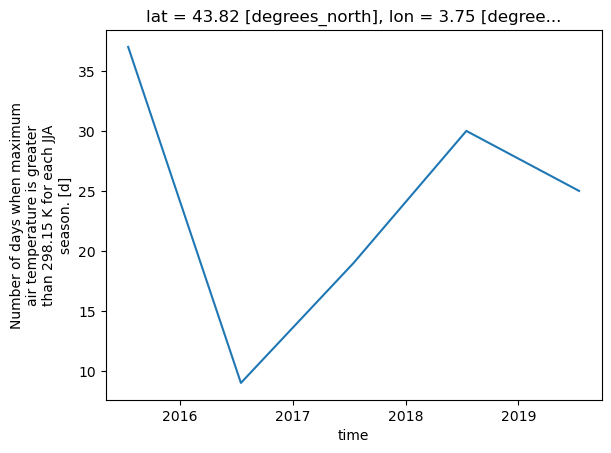

In [15]:
# Slice the data spatially using a single lat/lon point
one_point = su_xr["SU"].sel(lat=latitude, lon=longitude)

# Use xarray to create a quick time series plot
one_point.plot.line()
plt.show()

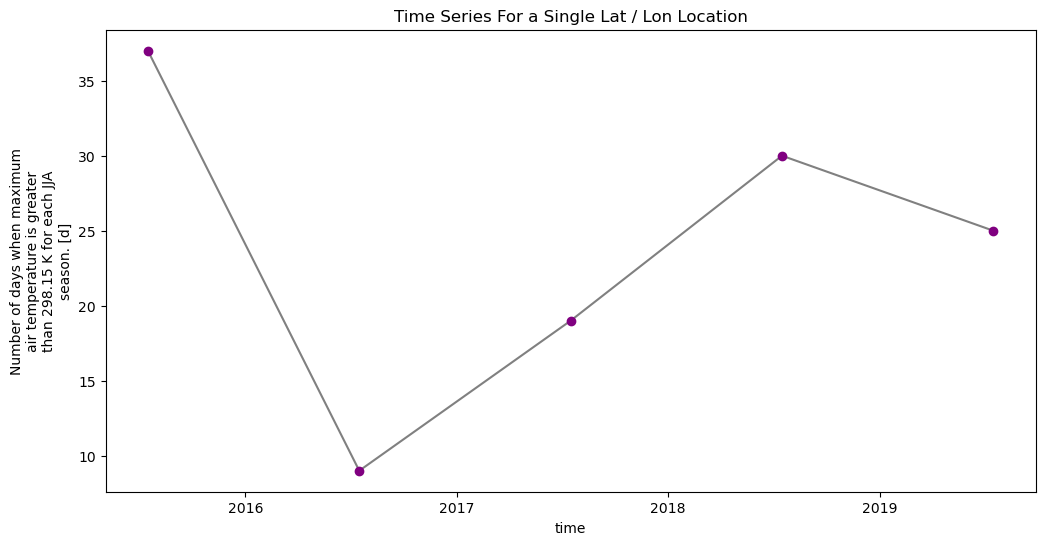

In [16]:
# You can clean up your plot as you wish using standard matplotlib approaches
f, ax = plt.subplots(figsize=(12, 6))
one_point.plot.line(
    hue="lat",
    marker="o",
    ax=ax,
    color="grey",
    markerfacecolor="purple",
    markeredgecolor="purple",
)
ax.set(title="Time Series For a Single Lat / Lon Location")

# Uncomment the line below if you wish to export the figure as a .png file
# plt.savefig("single_point_timeseries.png")
plt.show()

In [17]:
# Convert to dataframe -- then this can easily be exported to a csv
one_point_df = one_point.to_dataframe()
# View just the first 5 rows of the data
one_point_df.head()

# Export data to .csv file
# one_point_df.to_csv("one-location.csv")

,lat,lon,height,SU
time,,,,
2015-07-16 12:00:00,43.82199,3.75,2.0,37.0
2016-07-16 12:00:00,43.82199,3.75,2.0,9.0
2017-07-16 12:00:00,43.82199,3.75,2.0,19.0
2018-07-16 12:00:00,43.82199,3.75,2.0,30.0
2019-07-16 12:00:00,43.82199,3.75,2.0,25.0


In [18]:
# Time subsetting: this is just an example on how to do it
start_date = "2018-01-01"
end_date = "2019-12-31"

su = su_xr["SU"].sel(time=slice(start_date, end_date))

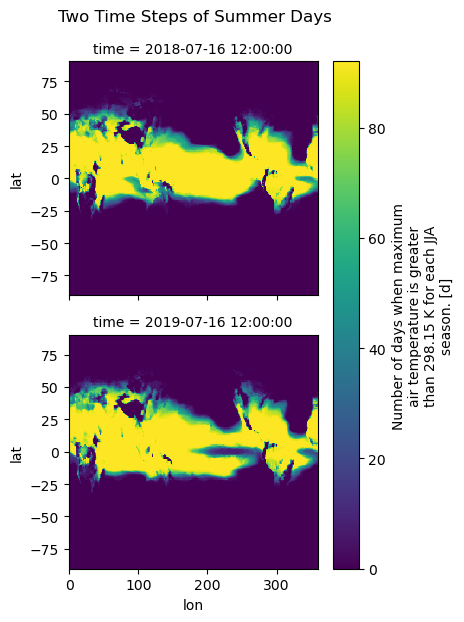

In [19]:
# Quickly plot the data using xarray.plot()
su.plot(x="lon", y="lat", col="time", col_wrap=1)

plt.suptitle("Two Time Steps of Summer Days", y=1.03)
plt.show()

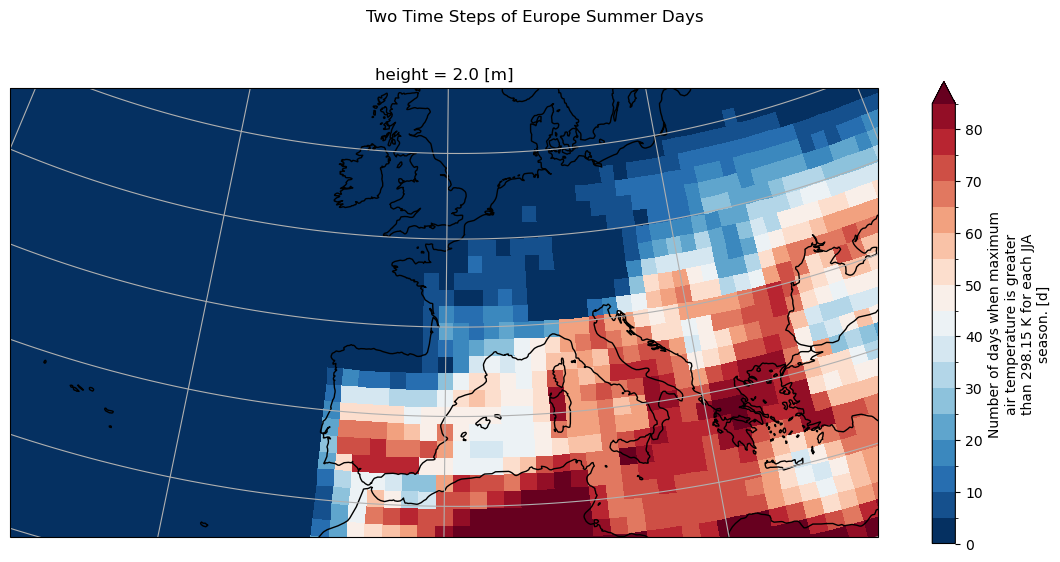

In [20]:
# Set spatial extent and centre
central_lat = 47.0
central_lon = 1.0
extent = [-30, 30, 30, 56]  # Western Europe

# Calculate time average
su_avg = su.mean(dim="time", keep_attrs=True)

# Set plot projection
map_proj = ccrs.AlbersEqualArea(
    central_longitude=central_lon, central_latitude=central_lat
)

# Define plot
f, ax = plt.subplots(figsize=(14, 6), subplot_kw={"projection": map_proj})

# Plot data with proper colormap scale range
levels = np.arange(0, 90, 5)
p = su_avg.plot(levels=levels, cmap="RdBu_r", transform=ccrs.PlateCarree())

# Plot information
plt.suptitle("Two Time Steps of Europe Summer Days", y=1)

# Add the coastlines to axis and set extent
ax.coastlines()
ax.gridlines()
ax.set_extent(extent)

# Save plot as png
plt.savefig("c4i_su_icclim.png")

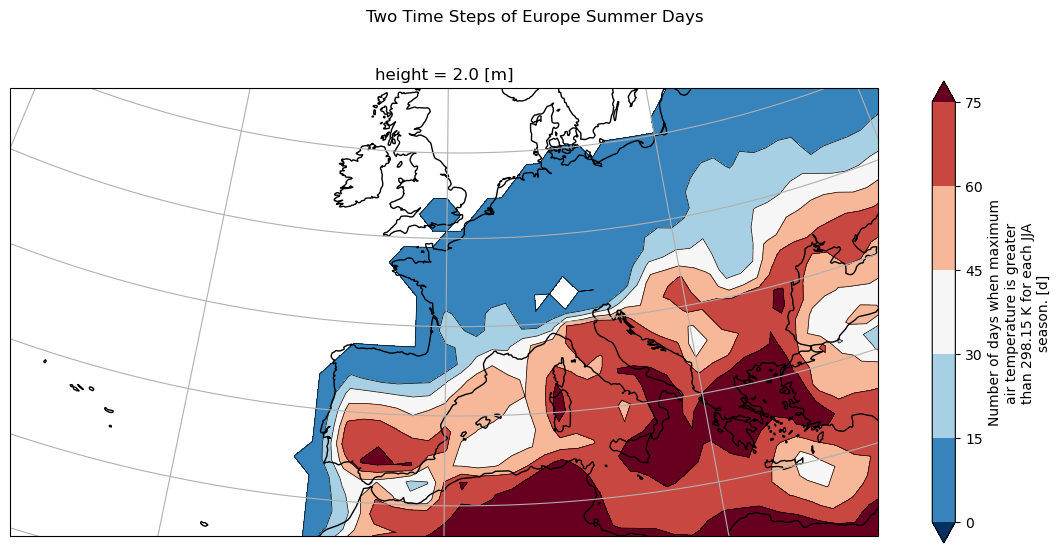

In [21]:
# Re-order longitude so that there is no blank line at 0 deg because 0 deg is within our spatial selection
su_avg.coords["lon"] = (su_avg.coords["lon"] + 180) % 360 - 180
su_avg = su_avg.sortby(su_avg.lon)

# Define plot
f, ax = plt.subplots(figsize=(14, 6), subplot_kw={"projection": map_proj})

# Define colorscale
levels = np.arange(0, 90, 15)

# Contours lines
p = su_avg.plot.contour(
    levels=levels, colors="k", linewidths=0.5, transform=ccrs.PlateCarree()
)

# Contour filled colors
p = su_avg.plot.contourf(
    levels=levels, cmap="RdBu_r", extend="both", transform=ccrs.PlateCarree()
)

# Plot information
plt.suptitle("Two Time Steps of Europe Summer Days", y=1)

# Add the coastlines to axis and set extent
ax.coastlines()
ax.gridlines()
ax.set_extent(extent)

# Save plot as png
plt.savefig("c4i_su_contours_icclim.png")